In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
df = pd.read_csv(r"C:\\FSDS\\Assessment\\FSDSmaster_assessment_10_03_2024\\notebooks\\data\\Benguluru.csv")

In [7]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [9]:
df.duplicated().sum()

529

There are 529 duplicated records, let's remove them.


In [10]:
df = df.drop_duplicates()
df.shape

(12791, 9)

In [11]:
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5328
total_sqft         0
bath              73
balcony          605
price              0
dtype: int64

Majorly missing values are in society, balcony, bath, size and location. We can drop society column as too many missing values

In [12]:
for col in df.columns:
    print(df[col].value_counts())
    print("*"*20)

area_type
Super built-up  Area    8317
Built-up  Area          2398
Plot  Area              1989
Carpet  Area              87
Name: count, dtype: int64
********************
availability
Ready To Move    10172
18-May             292
18-Dec             284
18-Apr             269
18-Aug             187
                 ...  
16-Oct               1
15-Dec               1
15-Jun               1
16-Jul               1
14-Jul               1
Name: count, Length: 81, dtype: int64
********************
location
Whitefield                        523
Sarjapur  Road                    379
Electronic City                   287
Kanakpura Road                    249
Thanisandra                       229
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: int64
********************
size
2 BHK    

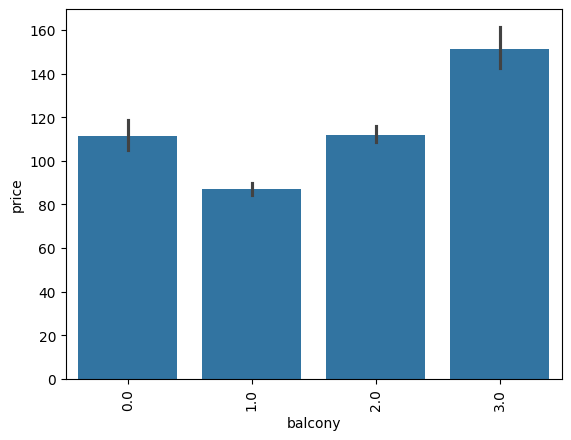

In [13]:
sns.barplot(x=df['balcony'], y=df['price'])
plt.xticks(rotation='vertical')
plt.show()

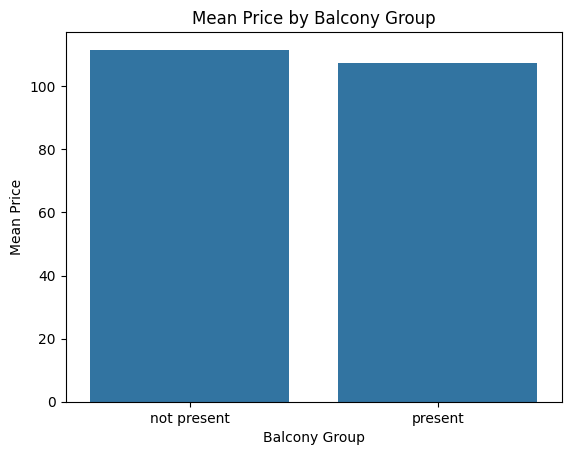

In [14]:
df['grouped_balcony'] = df['balcony'].apply(lambda x: 'present' if x in [1.0, 2.0, 3.0] else 'not present' if x==0.0 else None)
grouped_df = df.groupby('grouped_balcony')['price'].mean().reset_index()

# Plotting the bar plot
sns.barplot(x=grouped_df['grouped_balcony'], y=grouped_df['price'])
plt.xlabel('Balcony Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by Balcony Group')
plt.show()

In [15]:
df['availability'].value_counts()

availability
Ready To Move    10172
18-May             292
18-Dec             284
18-Apr             269
18-Aug             187
                 ...  
16-Oct               1
15-Dec               1
15-Jun               1
16-Jul               1
14-Jul               1
Name: count, Length: 81, dtype: int64

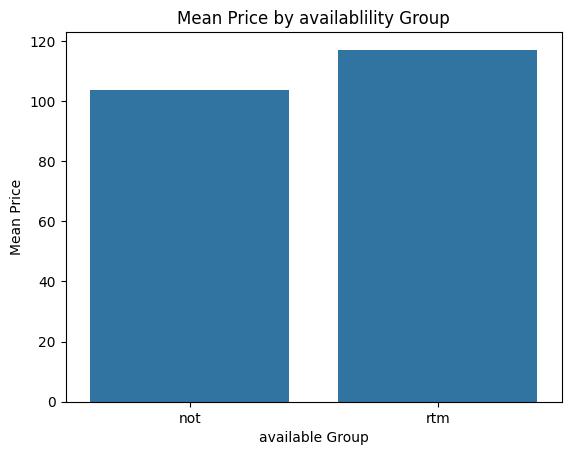

In [16]:
df['grouped_available'] = df['availability'].apply(lambda x: 'rtm' if x=='Ready To Move' else 'not')
grouped_df = df.groupby('grouped_available')['price'].mean().reset_index()

# Plotting the bar plot
sns.barplot(x=grouped_df['grouped_available'], y=grouped_df['price'])
plt.xlabel('available Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by availablility Group')
plt.show()

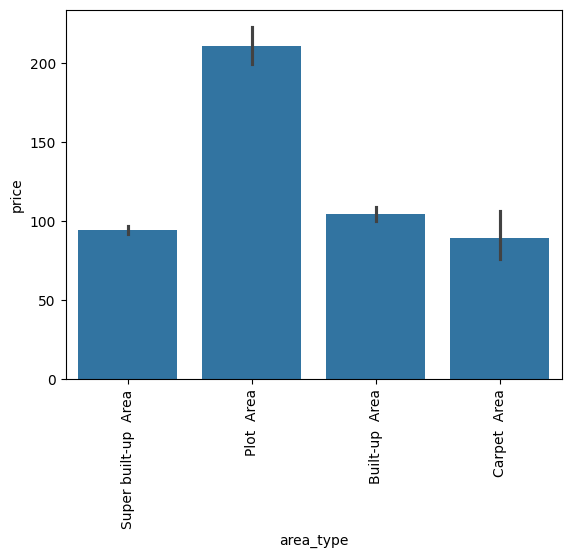

In [17]:
sns.barplot(x=df['area_type'], y=df['price'])
plt.xticks(rotation='vertical')
plt.show()

Availability group and area_type looks like important features as the price vary with them. We will keep them but drop balcony and society columns

In [18]:
df.drop(columns = ['balcony','society', 'grouped_balcony', 'grouped_available'], axis=1, inplace=True)

In [19]:
df.describe()

,bath,price
count,12718.000000,12791.000000
mean,2.708602,114.317646
std,1.357764,151.480310
min,1.000000,8.000000
25%,2.000000,50.000000
50%,2.000000,73.000000
75%,3.000000,121.000000
max,40.000000,3600.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12791 entries, 0 to 13318
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12791 non-null  object 
 1   availability  12791 non-null  object 
 2   location      12790 non-null  object 
 3   size          12775 non-null  object 
 4   total_sqft    12791 non-null  object 
 5   bath          12718 non-null  float64
 6   price         12791 non-null  float64
dtypes: float64(2), object(5)
memory usage: 799.4+ KB


In [21]:
df['location'].value_counts()

location
Whitefield                        523
Sarjapur  Road                    379
Electronic City                   287
Kanakpura Road                    249
Thanisandra                       229
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: int64

In [22]:
df['location'] = df['location'].fillna('Sarjapur  Road')

In [23]:
df['size'].value_counts()

size
2 BHK         4931
3 BHK         4120
4 Bedroom      824
4 BHK          574
3 Bedroom      535
1 BHK          521
2 Bedroom      314
5 Bedroom      291
6 Bedroom      191
1 Bedroom      104
8 Bedroom       84
7 Bedroom       82
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 BHK           2
11 Bedroom       2
10 BHK           2
14 BHK           1
13 BHK           1
12 Bedroom       1
27 BHK           1
43 Bedroom       1
16 BHK           1
19 BHK           1
18 Bedroom       1
Name: count, dtype: int64

In [24]:
df['size'] = df['size'].fillna('2 BHK')

In [25]:
df['bath']= df['bath'].fillna(df['bath'].median())

In [26]:
df['bhk'] = df['size'].str.split(" ").str[0].astype(int)

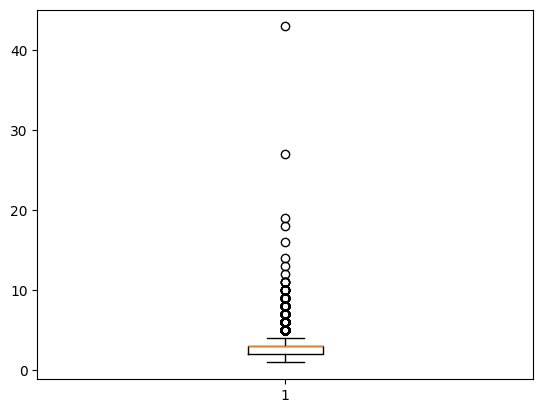

In [27]:
plt.boxplot(df['bhk'])
plt.show()

In [28]:
df[df['bhk']>20]

,area_type,availability,location,size,total_sqft,bath,price,bhk
1718,Super built-up Area,Ready To Move,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Plot Area,Ready To Move,Munnekollal,43 Bedroom,2400,40.0,660.0,43


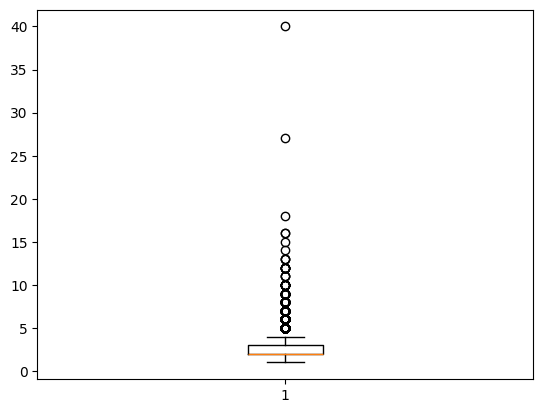

In [29]:
plt.boxplot(df['bath'])
plt.show()

In [30]:
#checking problamatic str values (ranges defined) in the total_sqft column

def check_str(val):
    try:
        float(val)
    except:
        return True
    return False

df[df['total_sqft'].apply(check_str)]


,area_type,availability,location,size,total_sqft,bath,price,bhk
30,Super built-up Area,19-Dec,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Built-up Area,20-Feb,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Built-up Area,18-Oct,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Super built-up Area,18-Mar,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,Super built-up Area,19-Mar,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
...,...,...,...,...,...,...,...,...
12975,Super built-up Area,20-Aug,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Super built-up Area,18-May,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Super built-up Area,Ready To Move,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13240,Super built-up Area,Ready To Move,Devanahalli,1 BHK,1020 - 1130,2.0,52.570,1


In [31]:
df.head()

,area_type,availability,location,size,total_sqft,bath,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,51.00,2


In [32]:
def convert_range(x):
    temp = x.split('-')
    if len(temp)==2:
        return (float(temp[0])+float(temp[1]))/2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_range)


In [33]:
df.isna().sum()

area_type        0
availability     0
location         0
size             0
total_sqft      46
bath             0
price            0
bhk              0
dtype: int64

In [34]:
df = df.dropna()

In [35]:
df.isna().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
price           0
bhk             0
dtype: int64

### Feature Engineering

Let's make a feature with price and total_sqft which we would be using to remove outliers

In [36]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']

In [37]:
df['price_per_sqft']

0         3699.810606
1         4615.384615
2         4305.555556
3         6245.890861
4         4250.000000
             ...     
13314     6530.612245
13315     6689.834926
13316    11111.111111
13317     5258.545136
13318    10407.336319
Name: price_per_sqft, Length: 12745, dtype: float64

In [38]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12745.00000,12745.000000,12745.000000,12745.000000,1.274500e+04
mean,1569.60368,2.703099,114.207350,2.815771,8.022896e+03
std,1259.83493,1.352340,151.591687,1.308425,1.086134e+05
min,1.00000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.00000,2.000000,50.000000,2.000000,4.298559e+03
50%,1280.00000,2.000000,73.000000,3.000000,5.482304e+03
75%,1691.00000,3.000000,120.000000,3.000000,7.398708e+03
max,52272.00000,40.000000,3600.000000,43.000000,1.200000e+07


In [39]:
df.location = df.location.apply(lambda x : x.strip())
loc_val = df['location'].value_counts()
loc_val

location
Whitefield                        522
Sarjapur  Road                    380
Electronic City                   289
Kanakpura Road                    247
Thanisandra                       231
                                 ... 
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Kannur                              1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1288, dtype: int64

In [40]:
to_be_others = loc_val[loc_val.values<=10].index

In [41]:
df['location'] = df['location'].apply(lambda x: 'others' if x in to_be_others else x)

df['location'].value_counts()

location
others              2924
Whitefield           522
Sarjapur  Road       380
Electronic City      289
Kanakpura Road       247
                    ... 
Doddaballapur         11
LB Shastri Nagar      11
Tindlu                11
HAL 2nd Stage         11
Banjara Layout        11
Name: count, Length: 233, dtype: int64

In [42]:
to_be_others

Index(['Marsur', 'Thyagaraja Nagar', 'BEML Layout', 'Narayanapura',
       'Gunjur Palya', 'Pattandur Agrahara', 'Naganathapura',
       'Nagappa Reddy Layout', 'BTM 1st Stage', '1st Block Koramangala',
       ...
       'Maruthi Extension', 'Okalipura', 'Old Town', 'Vasantapura main road',
       'Bapuji Layout', '1st Stage Radha Krishna Layout',
       'BEML Layout 5th stage', 'Kannur', 'singapura paradise',
       'Abshot Layout'],
      dtype='object', name='location', length=1056)

In [43]:
df.head()

,area_type,availability,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


### Outlier detection and removal

In [44]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12745.00000,12745.000000,12745.000000,12745.000000,1.274500e+04
mean,1569.60368,2.703099,114.207350,2.815771,8.022896e+03
std,1259.83493,1.352340,151.591687,1.308425,1.086134e+05
min,1.00000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.00000,2.000000,50.000000,2.000000,4.298559e+03
50%,1280.00000,2.000000,73.000000,3.000000,5.482304e+03
75%,1691.00000,3.000000,120.000000,3.000000,7.398708e+03
max,52272.00000,40.000000,3600.000000,43.000000,1.200000e+07


In [45]:
df = df[df['total_sqft']/df['bhk']>=300]
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000
mean,1606.223870,2.571643,113.252382,2.660644,6363.396694
std,1283.874933,1.090077,154.815223,0.988055,4226.681217
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1117.000000,2.000000,49.975000,2.000000,4250.000000
50%,1306.000000,2.000000,70.000000,3.000000,5330.490405
75%,1715.000000,3.000000,120.000000,3.000000,6967.569041
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


In [46]:
df.head()

,area_type,availability,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [47]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, val in df.groupby('location'):
        m = np.mean(val.price_per_sqft)
        std = np.std(val.price_per_sqft)

        gen_df = val[(val.price_per_sqft>=std-m) & (val.price_per_sqft<=std+m)]
        df_out = pd.concat([df_out,gen_df], ignore_index=True)

    return df_out

df = remove_pps_outliers(df)
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,10665.000000,10665.000000,10665.000000,10665.000000,10665.000000
mean,1536.625724,2.476981,90.165037,2.580684,5568.990001
std,1239.533013,1.001621,85.894598,0.923703,2285.591819
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1101.000000,2.000000,48.000000,2.000000,4121.750159
50%,1285.000000,2.000000,65.940000,2.000000,5084.745763
75%,1650.000000,3.000000,100.000000,3.000000,6370.370370
max,52272.000000,16.000000,2200.000000,16.000000,24509.803922


In [48]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

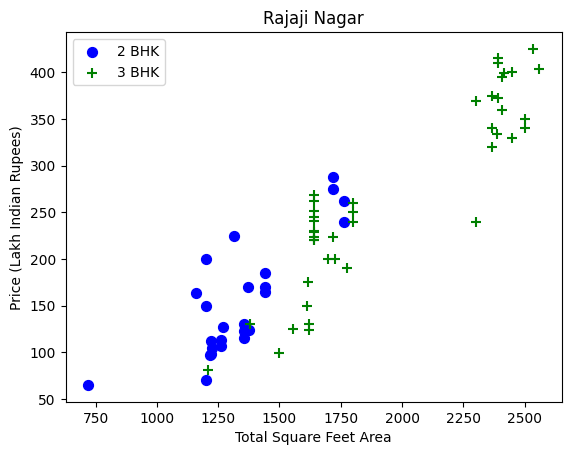

In [49]:
plot_scatter_chart(df,"Rajaji Nagar")

In [50]:
df.shape

(10665, 9)

In [51]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)
df.shape



(7736, 9)

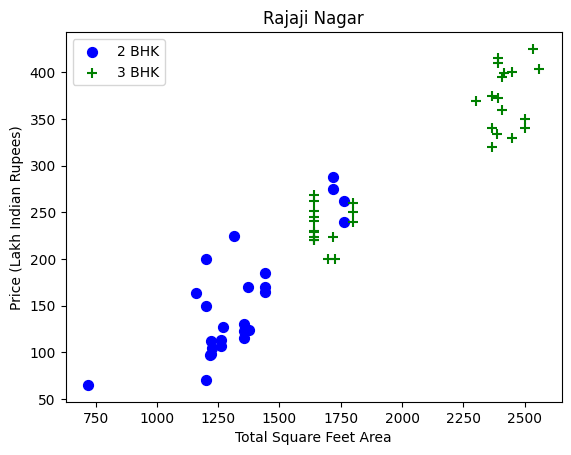

In [52]:
plot_scatter_chart(df,"Rajaji Nagar")

In [53]:
df.head()

,area_type,availability,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Super built-up Area,20-May,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,Super built-up Area,18-Jun,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,Super built-up Area,Ready To Move,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,Super built-up Area,Ready To Move,1st Block Jayanagar,2 BHK,1000.0,3.0,60.0,2,6000.000000
4,Built-up Area,15-Dec,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333


Let's drop unwanted columns - size, price_per_sqft

In [54]:
df.drop(['size', 'price_per_sqft'], axis=1, inplace= True)

In [55]:
df.head()

,area_type,availability,location,total_sqft,bath,price,bhk
0,Super built-up Area,20-May,1st Block Jayanagar,2850.0,4.0,428.0,4
1,Super built-up Area,18-Jun,1st Block Jayanagar,1630.0,3.0,194.0,3
2,Super built-up Area,Ready To Move,1st Block Jayanagar,1875.0,2.0,235.0,3
3,Super built-up Area,Ready To Move,1st Block Jayanagar,1000.0,3.0,60.0,2
4,Built-up Area,15-Dec,1st Block Jayanagar,1200.0,2.0,130.0,3


In [56]:
df['area_type'].value_counts()

area_type
Super built-up  Area    5567
Built-up  Area          1478
Plot  Area               644
Carpet  Area              47
Name: count, dtype: int64

In [57]:
df['availability'] = df['availability'].apply(lambda x: 1 if x=='Ready To Move' else 0)

In [58]:
df.describe()

,availability,total_sqft,bath,price,bhk
count,7736.000000,7736.000000,7736.000000,7736.000000,7736.000000
mean,0.786065,1512.258062,2.464064,98.467665,2.516934
std,0.410108,925.215282,1.040735,93.176479,0.954950
min,0.000000,300.000000,1.000000,8.440000,1.000000
25%,1.000000,1095.750000,2.000000,50.000000,2.000000
50%,1.000000,1260.500000,2.000000,72.830000,2.000000
75%,1.000000,1685.000000,3.000000,110.000000,3.000000
max,1.000000,30000.000000,16.000000,2200.000000,16.000000


In [59]:
df.shape

(7736, 7)

In [60]:
df = df[df.bath<df.bhk+2]

### Cleaned data

In [61]:
df.head()

,area_type,availability,location,total_sqft,bath,price,bhk
0,Super built-up Area,0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,Super built-up Area,0,1st Block Jayanagar,1630.0,3.0,194.0,3
2,Super built-up Area,1,1st Block Jayanagar,1875.0,2.0,235.0,3
3,Super built-up Area,1,1st Block Jayanagar,1000.0,3.0,60.0,2
4,Built-up Area,0,1st Block Jayanagar,1200.0,2.0,130.0,3


In [62]:
df.describe()

,availability,total_sqft,bath,price,bhk
count,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000
mean,0.786172,1489.046531,2.424389,96.110947,2.500719
std,0.410034,884.916801,0.966566,87.856816,0.938971
min,0.000000,300.000000,1.000000,8.440000,1.000000
25%,1.000000,1091.500000,2.000000,50.000000,2.000000
50%,1.000000,1259.000000,2.000000,72.000000,2.000000
75%,1.000000,1665.000000,3.000000,110.000000,3.000000
max,1.000000,30000.000000,16.000000,2200.000000,16.000000


In [63]:
X = df.drop(columns = ['price'])
y = df['price']

### Model building

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [65]:
print(X_train.shape)
print(X_test.shape)

(6120, 6)
(1531, 6)


In [66]:
X_train

,area_type,availability,location,total_sqft,bath,bhk
9499,Plot Area,1,others,1200.0,4.0,4
7195,Super built-up Area,1,Tumkur Road,1066.0,2.0,2
4562,Super built-up Area,1,Kenchenahalli,1280.0,2.0,3
1321,Super built-up Area,0,Bommanahalli,1250.0,3.0,3
4612,Super built-up Area,0,Kengeri,416.0,1.0,1
...,...,...,...,...,...,...
6050,Super built-up Area,1,Rajaji Nagar,2409.0,3.0,3
3972,Super built-up Area,0,Kadugodi,1314.0,2.0,2
1979,Super built-up Area,1,Electronic City,1070.0,2.0,2
3189,Super built-up Area,0,Hennur Road,1232.0,2.0,2


### SVR

In [67]:
step1 = ColumnTransformer(transformers=[
                         ('col_tnf', OneHotEncoder(sparse=False, drop='first'),[0,2])
                 ], remainder='passthrough')
step2 = StandardScaler()
step3 = SVR()

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2),
    ('step3', step3)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("R2 score ", r2_score(y_test, y_pred))
print("MAE score ", mean_absolute_error(y_test, y_pred))

R2 score  0.31486826625338016
MAE score  31.353958981535918
